## scButterfly on perturbation datasets

Except PBMC dataset with one type of perturbation, we will explore datasets with more than one. Our goal would be to try scButterfly for two isolated groups of perturbation types, similar with the PBMC use case. Then we will attempt to create a multi task architecture, by leveraging the information of both of these two perturbations.

Our goal would be to have an evaluation pipeline as well, and to test the potential of scButterfly to different perturbation datasets than the PBMC one. Potentially comparing it with other models as well.

In [103]:
from pertpy import data
import scanpy as sc

datasetdir = "../data"

sc.settings.datasetdir = datasetdir

sciplex_gxe1 = data.sciplex_gxe1()
combosciplex = data.combosciplex()
srivatsan_2020_sciplex2 = data.srivatsan_2020_sciplex2()
srivatsan_2020_sciplex3 = data.srivatsan_2020_sciplex3()


## Dataset sciplex1

In [104]:
sciplex_gxe1

AnnData object with n_obs × n_vars = 18585 × 58347
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'cell', 'sample', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W', 'top_to_second_best_ratio_W', 'top_oligo_W', 'RTwell', 'Ligwell', 'PCR_well', 'PCR_plate', 'new_cell', 'CRISPR_hash', 'gRNA_library', 'dose', 'treatment', 'time_point', 'protospacer_sequence', 'gRNA_id', 'gene_id', 'CRISPR_gRNA', 'guide_number'
    var: 'id', 'gene_short_name'

In [105]:
# sci-plex 
sciplex_gxe1.obs.groupby(['sample','treatment', 'dose']).size()

sample  treatment     dose 
0       dmso          0.0      3115
        temozolomide  0.1      1458
                      0.5      1454
                      1.0      1367
                      5.0      1191
                      10.0      919
                      50.0      695
                      100.0     620
        thioguanine   0.1      1902
                      0.5      1594
                      1.0      1372
                      5.0       986
                      10.0      754
                      50.0      606
                      100.0     552
dtype: int64

What are the control cells? Also the number of cell per perturbation seems low.

## Dataset combosciplex

In [106]:
combosciplex

AnnData object with n_obs × n_vars = 63378 × 27518
    obs: 'sample', 'Size_Factor', 'n.umi', 'RT_well', 'Drug1', 'Drug2', 'Well', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'condition', 'pathway1', 'pathway2', 'split', 'control', 'cell_type'
    var: 'id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Drug1_colors', 'Drug2_colors', 'Well_colors', 'condition_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pathway1_colors', 'pathway2_colors', 'pathway_colors', 'pca', 'rank_genes_groups', 'split_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [107]:
combosciplex.obs.groupby(['cell_type','condition', 'Drug1', 'Drug2']).size()

cell_type  condition                 Drug1         Drug2       
A549       Alvespimycin+Pirarubicin  Alvespimycin  Alvespimycin       0
                                                   Carmofur           0
                                                   Cediranib          0
                                                   Crizotinib         0
                                                   Curcumin           0
                                                                   ... 
           control+control           control       SRT2104            0
                                                   SRT3025            0
                                                   Sorafenib          0
                                                   Tanespimycin       0
                                                   control         1451
Length: 4608, dtype: int64

We are not interested on combinations of perturbations yet. So we won't use the combosciplex.

## Dataset sciplex2

In [108]:
srivatsan_2020_sciplex2


AnnData object with n_obs × n_vars = 24262 × 58347
    obs: 'ncounts', 'hash_umis', 'pval_demultiplexing', 'qval_demultiplexing', 'top_to_second_best_ratio', 'top_oligo', 'perturbation', 'dose_value', 'well', 'celltype', 'cell_line', 'cancer', 'disease', 'tissue_type', 'organism', 'perturbation_type', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'chembl-ID'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [109]:
print(srivatsan_2020_sciplex2.obs.groupby(['celltype','perturbation']).size())
print(srivatsan_2020_sciplex2.obs['perturbation'].value_counts())

celltype                         perturbation
alveolar basal epithelial cells  BMS             4183
                                 Dex             8064
                                 Nutlin          5956
                                 SAHA            5530
                                 control          529
dtype: int64
perturbation
Dex        8064
Nutlin     5956
SAHA       5530
BMS        4183
control     529
Name: count, dtype: int64


The sciplex2 has only a few control genes

## Dataset sciplex3

In [110]:
srivatsan_2020_sciplex3

AnnData object with n_obs × n_vars = 799317 × 110983
    obs: 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway_level_1', 'pathway_level_2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'cancer', 'tissue_type', 'organism', 'perturbation_type'
    var: 'ensembl_id'

### Preprocessing

In [111]:
# source sci-plex 2 preprocessing from CPA

sc.pp.filter_cells(srivatsan_2020_sciplex3, min_counts=500)
sc.pp.filter_cells(srivatsan_2020_sciplex3, min_genes=720)
sc.pp.filter_genes(srivatsan_2020_sciplex3, min_cells=100)
srivatsan_2020_sciplex3

AnnData object with n_obs × n_vars = 531604 × 31256
    obs: 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway_level_1', 'pathway_level_2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'cancer', 'tissue_type', 'organism', 'perturbation_type', 'n_counts', 'n_genes'
    var: 'ensembl_id', 'n_cells'

In [112]:
sc.pp.normalize_total(srivatsan_2020_sciplex3) # should this be per cell like https://github.com/facebookresearch/CPA/blob/main/preprocessing/sciplex3.ipynb? No, it is deprecated
sc.pp.log1p(srivatsan_2020_sciplex3)
sc.pp.highly_variable_genes(srivatsan_2020_sciplex3, n_top_genes=5000)
srivatsan_2020_sciplex3 = srivatsan_2020_sciplex3[:,srivatsan_2020_sciplex3.var.highly_variable]
srivatsan_2020_sciplex3

View of AnnData object with n_obs × n_vars = 531604 × 5000
    obs: 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway_level_1', 'pathway_level_2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'cancer', 'tissue_type', 'organism', 'perturbation_type', 'n_counts', 'n_genes'
    var: 'ensembl_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [113]:
srivatsan_2020_sciplex3.obs.groupby(['perturbation']).size().sort_values(ascending=False).head(20)

perturbation
control                     11600
Divalproex Sodium            3979
Ellagic acid                 3891
Ruxolitinib (INCB018424)     3890
Tazemetostat (EPZ-6438)      3856
Fasudil (HA-1077) HCl        3854
UNC1999                      3794
SRT3025 HCl                  3764
MC1568                       3737
Selisistat (EX 527)          3728
Iniparib (BSI-201)           3723
Resveratrol                  3699
SRT2104 (GSK2245840)         3694
EED226                       3679
G007-LK                      3669
FLLL32                       3644
Roxadustat (FG-4592)         3603
BMS-911543                   3600
PFI-1 (PF-6405761)           3583
Aurora A Inhibitor I         3561
dtype: int64

In [114]:
srivatsan_2020_sciplex3.var.value_counts() # these are not genes?

ensembl_id          n_cells  highly_variable  means     dispersions  dispersions_norm
ENSMUSG00000113701  1988     True             0.007033  1.299533     4.205728            1
ENSG00000000971     58153    True             0.135160  0.548921     1.162098            1
ENSG00000001084     127836   True             0.277511  0.736809     1.923961            1
ENSG00000002746     51730    True             0.119315  0.544947     1.145985            1
ENSG00000003096     37556    True             0.063178  0.566390     1.232935            1
                                                                                        ..
ENSG00000005249     50607    True             0.122364  0.710741     1.818257            1
ENSG00000005379     1388     True             0.003108  0.532177     1.094205            1
ENSG00000005421     5571     True             0.010838  0.411616     0.605347            1
ENSG00000005961     15777    True             0.031869  0.575118     1.268326            1
ENSG

In [115]:
srivatsan_2020_sciplex3.obs.groupby(['celltype']).size().sort_values(ascending=False)

celltype
mammary epithelial cells           279445
alveolar basal epithelial cells    140151
lymphoblasts                        91640
None                                20368
dtype: int64

choose the ones with the most amount of stimulated cell

In [116]:

dataset1 = srivatsan_2020_sciplex3[(srivatsan_2020_sciplex3.obs['perturbation'] == 'Ellagic acid') | (srivatsan_2020_sciplex3.obs['perturbation'] == 'control')]
print(dataset1.obs.groupby(['celltype', 'perturbation']).size())
dataset1.X = dataset1.X.toarray()


control1 = dataset1[dataset1.obs.perturbation == 'control']
perturb1 = dataset1[dataset1.obs.perturbation != 'control']
print(control1)
print(perturb1)

celltype                         perturbation
alveolar basal epithelial cells  Ellagic acid    1741
                                 control         3228
lymphoblasts                     Ellagic acid     470
                                 control         2076
mammary epithelial cells         Ellagic acid    1680
                                 control         6296
dtype: int64
View of AnnData object with n_obs × n_vars = 11600 × 5000
    obs: 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway_level_1', 'pathway_level_2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'cancer', 'tissue_type', 'organism', 'perturbation_type', 'n_counts', 'n_genes'
    var: 'ensembl_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
View of AnnData object with n_obs × n_vars = 3891 × 5000
    obs: 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway_level_1', 'p

In [117]:
dataset2 = srivatsan_2020_sciplex3[(srivatsan_2020_sciplex3.obs['perturbation'] == 'Divalproex Sodium') | (srivatsan_2020_sciplex3.obs['perturbation'] == 'control')]
print(dataset2.obs.groupby(['celltype', 'perturbation']).size())
dataset2.X = dataset2.X.toarray()

control2 = dataset2[dataset2.obs.perturbation == 'control']
perturb2 = dataset2[dataset2.obs.perturbation != 'control']
print(control2)
print(perturb2)

celltype                         perturbation     
alveolar basal epithelial cells  Divalproex Sodium    1673
                                 control              3228
lymphoblasts                     Divalproex Sodium     509
                                 control              2076
mammary epithelial cells         Divalproex Sodium    1797
                                 control              6296
dtype: int64
View of AnnData object with n_obs × n_vars = 11600 × 5000
    obs: 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway_level_1', 'pathway_level_2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'cancer', 'tissue_type', 'organism', 'perturbation_type', 'n_counts', 'n_genes'
    var: 'ensembl_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
View of AnnData object with n_obs × n_vars = 3979 × 5000
    obs: 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 

In [121]:
save = False
if save: 
    dataset1.write(f"{datasetdir}/sciplex3_dataset1.h5ad")
    dataset2.write(f"{datasetdir}/sciplex3_dataset2.h5ad")
else:
    dataset1 = sc.read_h5ad(f"{datasetdir}/sciplex3_dataset1.h5ad")
    dataset2 = sc.read_h5ad(f"{datasetdir}/sciplex3_dataset2.h5ad")


It seems that the sciplex3 for the perturbations 'Divalproex Sodium', and 'Ellagic acid', is a good candidate.

Some notes:
- There is a big gap between control cells (11594), and Ellagic acid (3891), and Divalproex Sodium (3979)
- To mitigate this, we could explore the augmentations utility from scButterfly

## scButtefly on sciplex3 for Ellagic acid and Divalproex Sodium perturbations

### Ellagic acid 

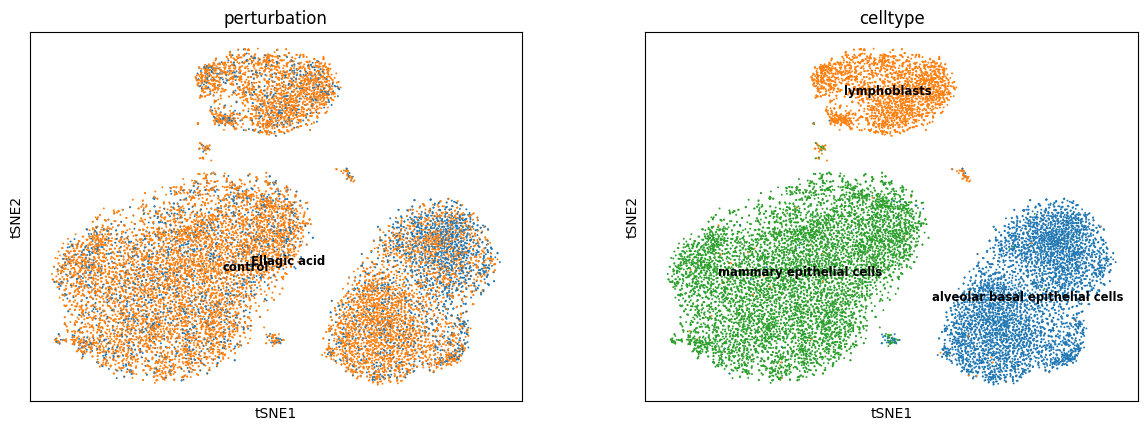

In [122]:
# simple inspection

sc.pp.pca(dataset1)
sc.pp.neighbors(dataset1)
sc.tl.tsne(dataset1)
sc.pl.tsne(dataset1, color=['perturbation', 'celltype'], legend_loc='on data', legend_fontsize='small')

In [ ]:
from scButterfly.train_model_perturb import Model
from scButterfly.split_datasets import unpaired_split_dataset_perturb
import torch
import torch.nn as nn

In [128]:
control1.obs["cell_type"] = control1.obs["celltype"]
perturb1.obs["cell_type"] = perturb1.obs["celltype"]
control1.obs['condition'] = 'control'
perturb1.obs['condition'] = 'stimulated'
control1.obs.index = [str(i) for i in range(control1.X.shape[0])]
perturb1.obs.index = [str(i) for i in range(perturb1.X.shape[0])]

RNA_input_dim = control1.X.shape[1]
ATAC_input_dim = perturb1.X.shape[1]

R_kl_div = 1 / RNA_input_dim * 20
A_kl_div = 1 / ATAC_input_dim * 20
kl_div = R_kl_div + A_kl_div

dataset = "ellagic_acid"

file_path = f"../saved_results/butterfly/perturb/{dataset}"

# split data
id_list, id_list_dict = unpaired_split_dataset_perturb(control1, perturb1)
idx = 0
train_id_control, train_id_perturb, validation_id_control, validation_id_perturb, test_id_control, test_id_perturb = id_list[idx]

control1[test_id_control].obs["celltype"]


optimal transport array torch.Size([3228, 1741])
alveolar basal epithelial cells, control num 3228 stimulate num 1741

optimal transport array torch.Size([2076, 470])
lymphoblasts, control num 2076 stimulate num 470

optimal transport array torch.Size([6296, 1680])
mammary epithelial cells, control num 6296 stimulate num 1680


Start alveolar basal epithelial cells
Batch list ['mammary epithelial cells', 'alveolar basal epithelial cells', 'lymphoblasts']
Test batch control ['mammary epithelial cells']
Validation batch control ['alveolar basal epithelial cells', 'lymphoblasts']
Train batch control ['alveolar basal epithelial cells', 'lymphoblasts']
Test batch stimulated ['mammary epithelial cells']
Validation batch stimulated ['alveolar basal epithelial cells', 'lymphoblasts']
Train batch stimulated ['alveolar basal epithelial cells', 'lymphoblasts']
End alveolar basal epithelial cells

train len 2582 valid len 646
id_list
2582
2582
646
646
6296
1680

train len 1660 valid len 416
id_lis

In [130]:
model_perturb1 = Model(
    R_encoder_nlayer = 2, 
    A_encoder_nlayer = 2,
    R_decoder_nlayer = 2, 
    A_decoder_nlayer = 2,
    R_encoder_dim_list = [RNA_input_dim, 256, 128],
    A_encoder_dim_list = [ATAC_input_dim, 128, 128],
    R_decoder_dim_list = [128, 256, RNA_input_dim],
    A_decoder_dim_list = [128, 128, ATAC_input_dim],
    R_encoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    A_encoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    R_decoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    A_decoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    translator_embed_dim = 128, 
    translator_input_dim_r = 128,
    translator_input_dim_a = 128,
    translator_embed_act_list = [nn.LeakyReLU(), nn.LeakyReLU(), nn.LeakyReLU()],
    discriminator_nlayer = 1,
    discriminator_dim_list_R = [128],
    discriminator_dim_list_A = [128],
    discriminator_act_list = [nn.Sigmoid()],
    dropout_rate = 0.1,
    R_noise_rate = 0.5,
    A_noise_rate = 0.5,
    chrom_list = [],
    logging_path = file_path,
    RNA_data = control1,
    ATAC_data = perturb1
)

In [132]:
train = False
model_perturb1.train(
    R_encoder_lr = 0.001,
    A_encoder_lr = 0.001,
    R_decoder_lr = 0.001,
    A_decoder_lr = 0.001,
    R_translator_lr = 0.001,
    A_translator_lr = 0.001,
    translator_lr = 0.001,
    discriminator_lr = 0.005,
    R2R_pretrain_epoch = 100,
    A2A_pretrain_epoch = 100,
    lock_encoder_and_decoder = False,
    translator_epoch = 200,
    patience = 50,
    batch_size = 64,
    r_loss = nn.MSELoss(size_average=True),
    a_loss = nn.MSELoss(size_average=True),
    d_loss = nn.BCELoss(size_average=True),
    loss_weight = [1, 1, 1, R_kl_div, A_kl_div, kl_div],
    train_id_r = train_id_control,
    train_id_a = train_id_perturb,
    validation_id_r = validation_id_control, 
    validation_id_a = validation_id_perturb, 
    output_path = file_path,
    seed = 19193,
    kl_mean = True,
    R_pretrain_kl_warmup = 50,
    A_pretrain_kl_warmup = 50,
    translation_kl_warmup = 50,
    load_model = None if train else file_path,
    logging_path = file_path
)

[INFO] Trainer: Control pretraining ...
[INFO] Trainer: Control pretraining ...
Control pretrain: 100%|█████████████████| 100/100 [06:39<00:00,  3.99s/it, train=0.0306, val=0.0317]
[INFO] Trainer: Stimulated pretraining ...
[INFO] Trainer: Stimulated pretraining ...
Stimulated pretrain: 100%|██████████████| 100/100 [06:41<00:00,  4.02s/it, train=0.0313, val=0.0322]
[INFO] Trainer: Integrative training ...
[INFO] Trainer: Integrative training ...
Integrative training: 100%|█████████████| 200/200 [20:04<00:00,  6.02s/it, train=0.1277, val=0.1241]


[INFO] Tester: get predicting ...
stimulated to control predicting...: 100%|██████████████████████████| 17/17 [00:01<00:00,  8.92it/s]
[INFO] Tester: calculate neighbors graph for following test ...


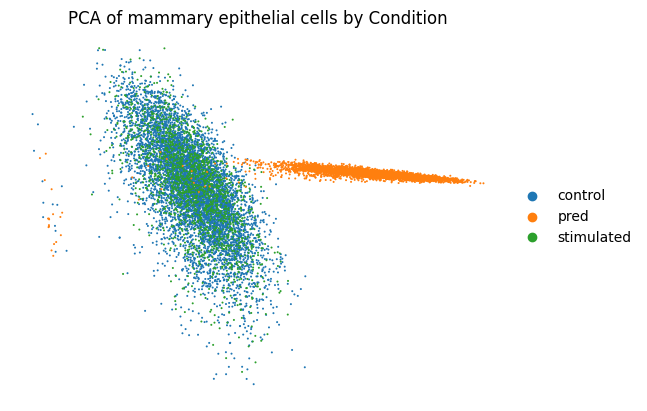

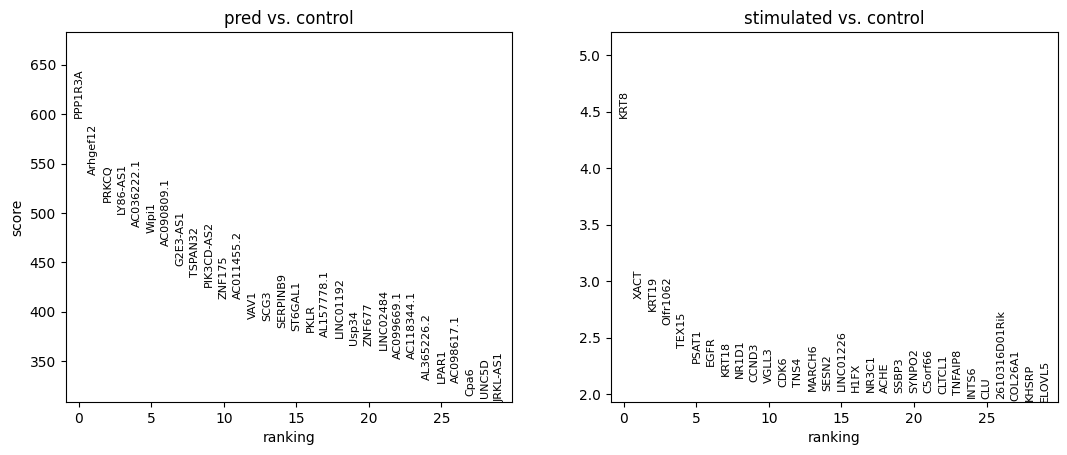

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


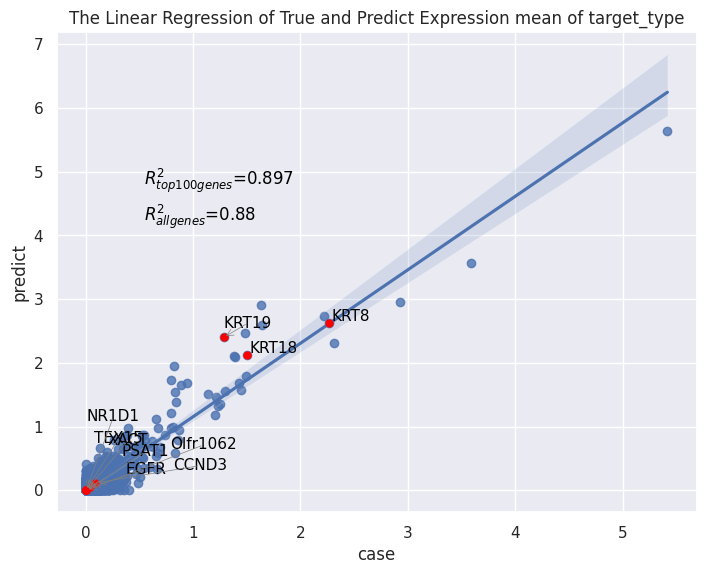

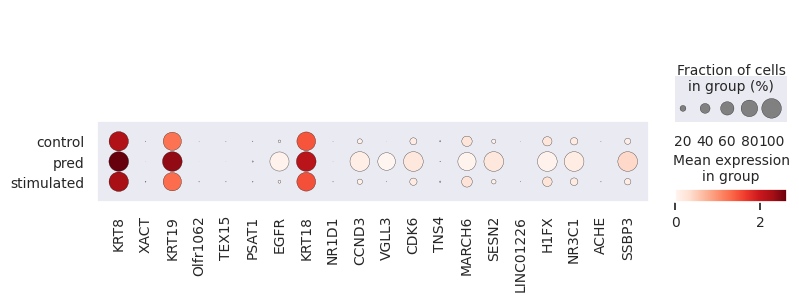

In [133]:
model_perturb1.test(
    test_id_r = test_id_control,
    test_id_a = test_id_perturb,
    model_path = file_path,
    load_model = None if train else file_path,
    output_path = file_path,
    test_pca = True,
    test_DEGs = True,
    test_R2 = True,
    test_dotplot = True,
    output_data = False,
    return_predict = False
)

In [ ]:
import pandas as pd
cluster_index = pd.read_csv('cluster_index.csv', index_col=0)
cluster_index

### Ellagic acid with augmentation

In [134]:
# I should explore the augmentation of scbutterfly

### Divalproex Sodium 

In [ ]:
control2.obs["cell_type"] = control2.obs["celltype"]
perturb2.obs["cell_type"] = perturb2.obs["celltype"]
control2.obs['condition'] = 'control'
perturb2.obs['condition'] = 'stimulated'
control2.obs.index = [str(i) for i in range(control2.X.shape[0])]
perturb2.obs.index = [str(i) for i in range(perturb2.X.shape[0])]

RNA_input_dim = control2.X.shape[1]
ATAC_input_dim = perturb2.X.shape[1]

R_kl_div = 1 / RNA_input_dim * 20
A_kl_div = 1 / ATAC_input_dim * 20
kl_div = R_kl_div + A_kl_div

dataset = "divalproex_sodium"

file_path = f"../saved_results/butterfly/perturb/{dataset}"

# split data
id_list, id_list_dict = unpaired_split_dataset_perturb(control2, perturb2)
idx = 0
train_id_control, train_id_perturb, validation_id_control, validation_id_perturb, test_id_control, test_id_perturb = id_list[idx]

control2[test_id_control].obs["celltype"]


In [ ]:
model_perturb2 = Model(
    R_encoder_nlayer = 2, 
    A_encoder_nlayer = 2,
    R_decoder_nlayer = 2, 
    A_decoder_nlayer = 2,
    R_encoder_dim_list = [RNA_input_dim, 256, 128],
    A_encoder_dim_list = [ATAC_input_dim, 128, 128],
    R_decoder_dim_list = [128, 256, RNA_input_dim],
    A_decoder_dim_list = [128, 128, ATAC_input_dim],
    R_encoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    A_encoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    R_decoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    A_decoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    translator_embed_dim = 128, 
    translator_input_dim_r = 128,
    translator_input_dim_a = 128,
    translator_embed_act_list = [nn.LeakyReLU(), nn.LeakyReLU(), nn.LeakyReLU()],
    discriminator_nlayer = 1,
    discriminator_dim_list_R = [128],
    discriminator_dim_list_A = [128],
    discriminator_act_list = [nn.Sigmoid()],
    dropout_rate = 0.1,
    R_noise_rate = 0.5,
    A_noise_rate = 0.5,
    chrom_list = [],
    logging_path = file_path,
    RNA_data = control2,
    ATAC_data = perturb2
)

In [ ]:
model_perturb2.train(
    R_encoder_lr = 0.001,
    A_encoder_lr = 0.001,
    R_decoder_lr = 0.001,
    A_decoder_lr = 0.001,
    R_translator_lr = 0.001,
    A_translator_lr = 0.001,
    translator_lr = 0.001,
    discriminator_lr = 0.005,
    R2R_pretrain_epoch = 100,
    A2A_pretrain_epoch = 100,
    lock_encoder_and_decoder = False,
    translator_epoch = 200,
    patience = 50,
    batch_size = 64,
    r_loss = nn.MSELoss(size_average=True),
    a_loss = nn.MSELoss(size_average=True),
    d_loss = nn.BCELoss(size_average=True),
    loss_weight = [1, 1, 1, R_kl_div, A_kl_div, kl_div],
    train_id_r = train_id_control,
    train_id_a = train_id_perturb,
    validation_id_r = validation_id_control, 
    validation_id_a = validation_id_perturb, 
    output_path = file_path,
    seed = 19193,
    kl_mean = True,
    R_pretrain_kl_warmup = 50,
    A_pretrain_kl_warmup = 50,
    translation_kl_warmup = 50,
    load_model = None,
    logging_path = file_path
)

In [ ]:
model_perturb2.test(
    test_id_r = test_id_control,
    test_id_a = test_id_perturb, 
    model_path = file_path,
    load_model = False,
    output_path = file_path,
    test_pca = True,
    test_DEGs = True,
    test_R2 = True,
    test_dotplot = True,
    output_data = False,
    return_predict = False
)

In [ ]:
import pandas as pd
cluster_index = pd.read_csv('cluster_index.csv', index_col=0)
cluster_index